<a id='start'></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель исследования:**<br> 
построить модель для определения стоимости.

**Задачи исследования:**
1. [Открыть файл и изучить его;](#step1)
2. [Провести предварительную обработку данных;](#step2)
3. [Подготовить данные для обучения: разделить на выборки, закодировать, отмасштабировать;](#step3)
4. [Обучить различные модели, варьируя гиперпараметры;](#step4)
5. [Выбрать наилучшую модель;](#step5)
6. [Подвести итоги.](#step6)


Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<a id='step1'></a>

## Подготовка данных

Импорт необходимых библиотек

In [2]:
import datetime as dt
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

Чтение файла с данными

In [5]:
data_initial = pd.read_csv('autos.csv')
data_initial.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Имеем дело с признаками:**<br> 
DateCrawled — дата скачивания анкеты из базы - не влияет на целевой признак<br>
VehicleType — тип автомобильного кузова<br> 
RegistrationYear — год регистрации автомобиля - дает представление о возрасте автомобиля<br> 
Gearbox — тип коробки передач<br> 
Power — мощность (л. с.)<br> 
Model — модель автомобиля<br> 
Kilometer — пробег (км)<br> 
RegistrationMonth — месяц регистрации автомобиля - не влияет на целевой признак<br> 
FuelType — тип топлива<br> 
Brand — марка автомобиля<br> 
Repaired — была машина в ремонте или нет<br> 
DateCreated — дата создания анкеты - позволит оценить давно ли размещено объвление<br>
NumberOfPictures — количество фотографий автомобиля - не влияет на целевой признак<br>
PostalCode — почтовый индекс владельца анкеты (пользователя) - не влияет на целевой признак<br> 
LastSeen — дата последней активности пользователя - не влияет на целевой признак<br> 


**Целевой признак:**<br>
Price — цена (евро)

Исследование пропусков и типов данных

In [6]:
data_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В столбце "Repaired" есть большое количество пропусков, в остальных столбцах пропусков не так много. 

Посмотрим на распределение значений в некоторых столбцах

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

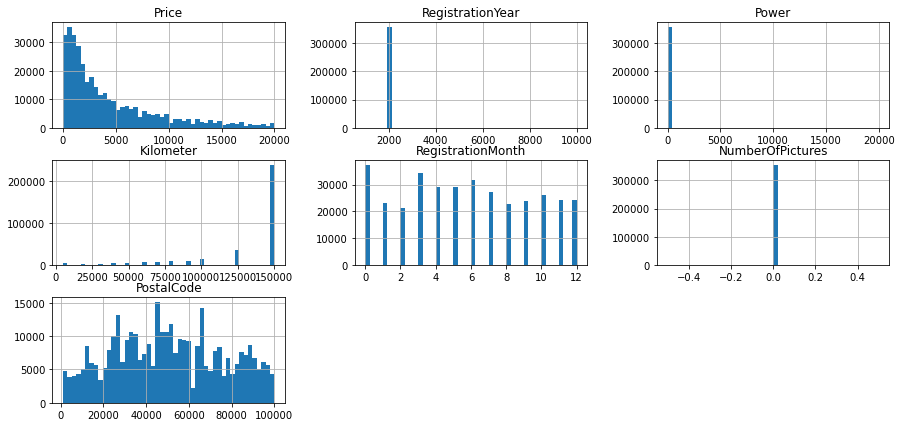

In [7]:
data_initial.hist(bins=48, figsize=(15,7))

Вопросы вызывают столбцы "RegistrationYear" и "Power": видно, что есть аномалии.

<a id='step2'></a>

Посмотрим, есть ли дубликаты в данных

In [8]:
data_initial.duplicated().sum()

4

Есть повторяющиеся объекты, удалим их.

Для редакирования данных создадим новую переменную.

In [9]:
data = data_initial.copy()

In [10]:
data = data.drop_duplicates().reset_index(drop=True)

Взглянем на уникальные значения столбца "RegistrationYear"

In [11]:
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Явно здесь присутствуют ошибки. Оставим данные за вторую половину прошлого века и до настоящего времени, остальное удалим, если таких данных немного.

In [12]:
len(data.loc[(data['RegistrationYear'] > 2019) | (data['RegistrationYear'] < 1950)])

351

Данных немного, смело удаляем.

In [13]:
data = data.loc[(data['RegistrationYear'] <= 2019) & (data['RegistrationYear'] >= 1950)]

Посмотрим на уникальные значения столбца "Power"

In [14]:
data['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [15]:
data['Power'].sort_values().value_counts()

0        39971
75       24020
60       15894
150      14589
101      13298
         ...  
1202         1
1221         1
1223         1
1230         1
20000        1
Name: Power, Length: 711, dtype: int64

Здесь также заметны аномальные значения: одних только автомобилей с мощностью двигателя 0 л.с. больше 40 тысяч. Помимо этого есть автомобили с мощностью двигателя более 1000 л.с., хотя при исследовании данных гиперкаров обнаружено не было. Для автомобилей с мощностью двигателя более 1000 л.с. скорее всего предполагались значения на порядок меньше, для автомобилей с мощностью двигателя более 10000 л.с., соответственно, предполагались значения на два порядка меньше. Изменим эти значения поделив их на 10 и на 100. Значения для мощности меньше 10 л.с. заменим на медианные.

In [16]:
data.loc[(data['Power'] >= 1000), 'Power'] = data['Power'] / 10
data.loc[(data['Power'] >= 10000), 'Power'] = data['Power'] / 100

In [17]:
len(data.loc[data['Power'] < 10])

40188

In [18]:
data.loc[data['Power'] < 10, 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')

В данных встречаются автомобили с мощностью 0, вряд ли продавцы указывают мощность 0, если хотят продать машину без двигателя, думаю тут другая причина кроется. Вероятно, для таких автомобилей должна быть отдельная категория.

Вероятно, на цену автомобиля может то, насколько давно объявление было выложено, относительно сегодняшнего дня. Создадим соответствующий столбец.

In [19]:
data['DaysPublished'] = (dt.datetime.now() - pd.to_datetime(data['DateCreated'])).dt.days

In [20]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysPublished
0,2016-03-24 11:52:17,480,NaN,1993,manual,101,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2669
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2669
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2679
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2676
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,2662


Для более простых моделей необходимо заполнить пропуски или удалить их. Создадим датафрейм, с  которым будут работать обычные модели машинного обучения. У датафреймов для обучения простых моделей название оканчивается на _full.

Посмотрим на количество данных, где не указана модель автомобиля

In [21]:
len(data.loc[data['Model'].isna()])

13224

Эти данные также можно удалить

In [22]:
data = data.loc[~data['Model'].isna()]

Пропуски в 'Gearbox' заменим наиболее частым значением для каждой модели.

In [23]:
len(data.loc[data['Gearbox'].isna()])

15597

In [24]:
data['Gearbox'] = data['Gearbox'].fillna(data
                                         .groupby('Model')['Gearbox']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

Пропуски в 'VehicleType' заменим заглушкой 'unknown'.
Пропуски в 'FuelType' заменим наиболее частым значением для каждой модели.

In [25]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

data['FuelType'] = data['FuelType'].fillna(data
                                           .groupby('Model')['FuelType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

Проверим количество пропусков в "Repaired".

In [26]:
len(data[data['Repaired'].isna()])

61964

Пропусков много. Вероятнее всего, если не было отметки о ремонте, то ремонта автомобиля не было. Заполним пропуски значением "no".

In [27]:
data['Repaired'].fillna('no', inplace=True)

In [28]:
data['FuelType'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

В столбце "FuelType" есть две категории топлива, означающих одно и то же: petrol и gasoline - это бензин, который в разных странах называют по-разному. Это тоже может нести в себе важную информацию. Например, по этому, вероятно, можно судить о сборке автомобиля: на gasoline будут ездить автомобили, собранные для США, скорость которых на спидометрах будет показываться в милях.

Посмотрим, остались ли пропуски в датасете для обучения простых моделей

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334474 entries, 0 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        334474 non-null  object
 1   Price              334474 non-null  int64 
 2   VehicleType        334474 non-null  object
 3   RegistrationYear   334474 non-null  int64 
 4   Gearbox            334474 non-null  object
 5   Power              334474 non-null  int64 
 6   Model              334474 non-null  object
 7   Kilometer          334474 non-null  int64 
 8   RegistrationMonth  334474 non-null  int64 
 9   FuelType           334474 non-null  object
 10  Brand              334474 non-null  object
 11  Repaired           334474 non-null  object
 12  DateCreated        334474 non-null  object
 13  NumberOfPictures   334474 non-null  int64 
 14  PostalCode         334474 non-null  int64 
 15  LastSeen           334474 non-null  object
 16  DaysPublished      3

Пропусков не осталось.

Изучим аномалии в целевом признаке

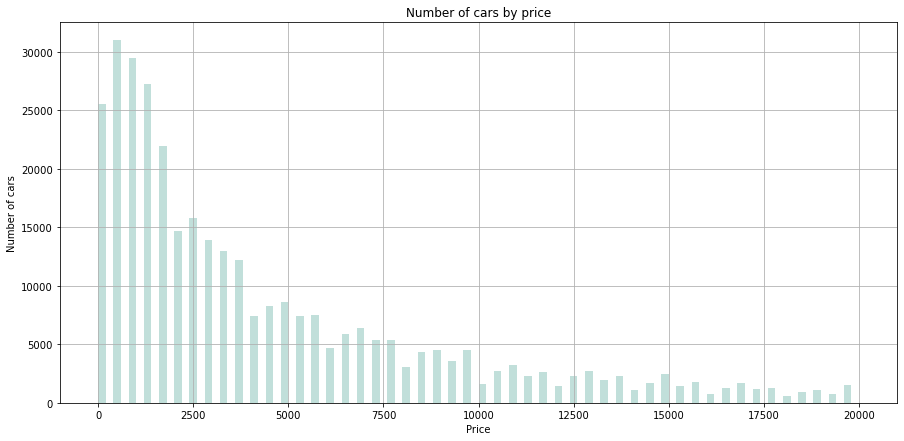

In [30]:
data['Price'].hist(bins=50,  figsize=(15, 7), color='#A7D2CB', width=200, alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Number of cars')
plt.title('Number of cars by price')
plt.show()

In [28]:
data['Price'].sort_values().value_counts()

0        8560
500      5209
1500     4997
1200     4298
1000     4249
         ... 
3988        1
14227       1
11920       1
1429        1
8188        1
Name: Price, Length: 3670, dtype: int64

Почти в 11 тысяч случаев указана цена 0. У этого могут быть разные причины, вряд ли все эти владельцы отдают свои автомобили бесплатно.

In [29]:
data.loc[data['Price'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DaysPublished
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58,2608
40,2016-03-26 22:06:17,0,unknown,1990,manual,60,corsa,150000,1,petrol,opel,no,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34,2603
111,2016-03-19 18:40:12,0,unknown,2017,manual,101,golf,5000,12,petrol,volkswagen,no,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05,2610
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10,2618
154,2016-03-22 16:37:59,0,unknown,2006,manual,116,other,5000,0,petrol,fiat,no,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56,2607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354201,2016-03-09 15:56:30,0,unknown,2000,manual,65,corsa,150000,0,petrol,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08,2620
354234,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,no,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23,2609
354244,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,no,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24,2605
354273,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32,2619


За 0 отдают совершенно разные автомобили: и новые, и старые, и микроавтобусы, и малолитражки. Удалим данные с ценой 0.

In [30]:
data = data.loc[data['Price'] != 0]

In [31]:
data = data.reset_index(drop=True)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325914 entries, 0 to 325913
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        325914 non-null  object
 1   Price              325914 non-null  int64 
 2   VehicleType        325914 non-null  object
 3   RegistrationYear   325914 non-null  int64 
 4   Gearbox            325914 non-null  object
 5   Power              325914 non-null  int64 
 6   Model              325914 non-null  object
 7   Kilometer          325914 non-null  int64 
 8   RegistrationMonth  325914 non-null  int64 
 9   FuelType           325914 non-null  object
 10  Brand              325914 non-null  object
 11  Repaired           325914 non-null  object
 12  DateCreated        325914 non-null  object
 13  NumberOfPictures   325914 non-null  int64 
 14  PostalCode         325914 non-null  int64 
 15  LastSeen           325914 non-null  object
 16  DaysPublished      3

Посмотрим сколько объектов осталось от первоначального количества.

In [33]:
(data.shape[0] / data_initial.shape[0]) * 100

91.97023441666737

Потеряли некритичное количество данных.

Таким образом, были обработаны аномалии в столбцах "Power", "RegisrationYear" и "Price". Также обработаны пропущенные значения в датасете для обучения моделей.

<a id='step3'></a>

## Обучение моделей

Разобьем данные на обучающую, валидационную и тестовую выборки.

Выделим из данных признаки, влияющие на целевой признак, и сам целевой признак.

In [34]:
drop_features = ['Price', 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'DateCreated', 'PostalCode', 'LastSeen']

In [35]:

data_train, data_test = train_test_split(data, test_size=0.2, random_state=12345)
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=12345)

features_train = data_train.drop(drop_features, axis=1)
target_train = data_train['Price']

features_valid = data_valid.drop(drop_features, axis=1)
target_valid = data_valid['Price']

features_test = data_test.drop(drop_features, axis=1)
target_test = data_test['Price']

Закодируем данные с помощью Ordinal Encoder.

In [36]:
features_categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand', 'RegistrationYear']

In [37]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(features_train[features_categorical])

def features_oe(oe_variable, df_features, features_categ):
    df_features_oe = pd.DataFrame(
        data=oe_variable.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=df_features[features_categ].columns
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_oe)
    return df_features    

features_train = features_oe(oe, features_train, features_categorical);
features_valid = features_oe(oe, features_valid, features_categorical);
features_test = features_oe(oe, features_test, features_categorical);

Отмасштабируем признаки числового формата

In [38]:
numeric = ['Power', 'Kilometer', 'DaysPublished']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

<a id='step4'></a>

Приступим к обучению. Начнем с простых моделей.

Первая модель - решающее дерево. Будем варьировать параметр глубины. Задача получить наименьший RMSE, при этом значение должно быть меньше 2500.

**Решающее дерево**

In [39]:
%%time

best_model_tree = None
best_result_tree = 3000
best_depth = 0
depth_plot = []
result_plot = []
for depth in tqdm(range(4, 26)):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions, squared=False)
    print(f'max_depth = {depth} : {result}')
    
    depth_plot.append(depth)
    result_plot.append(result)
    
    if result < best_result_tree:
        best_model_tree = model # сохраняем наилучшую модель
        best_result_tree = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth # глубина с лучшим значеним accuracy
        
print('RMSE наилучшей модели на валидационной выборке:', best_result_tree)
print('Глубина:', best_depth)

  5%|▍         | 1/22 [00:00<00:04,  4.70it/s]

max_depth = 4 : 2673.1173825807095


  9%|▉         | 2/22 [00:00<00:04,  4.36it/s]

max_depth = 5 : 2455.0651313461676


 14%|█▎        | 3/22 [00:00<00:05,  3.78it/s]

max_depth = 6 : 2316.948199909966


 18%|█▊        | 4/22 [00:01<00:05,  3.42it/s]

max_depth = 7 : 2208.857813575968


 23%|██▎       | 5/22 [00:01<00:05,  3.07it/s]

max_depth = 8 : 2128.458845065033


 27%|██▋       | 6/22 [00:01<00:05,  2.77it/s]

max_depth = 9 : 2073.4882538224233


 32%|███▏      | 7/22 [00:02<00:05,  2.59it/s]

max_depth = 10 : 2023.1204832752246


 36%|███▋      | 8/22 [00:02<00:05,  2.35it/s]

max_depth = 11 : 1973.5956912691354


 41%|████      | 9/22 [00:03<00:05,  2.21it/s]

max_depth = 12 : 1934.0115528695044


 45%|████▌     | 10/22 [00:03<00:05,  2.07it/s]

max_depth = 13 : 1929.3240078247668


 50%|█████     | 11/22 [00:04<00:05,  1.94it/s]

max_depth = 14 : 1925.0044173580416


 55%|█████▍    | 12/22 [00:05<00:05,  1.82it/s]

max_depth = 15 : 1940.458733481739


 59%|█████▉    | 13/22 [00:05<00:05,  1.71it/s]

max_depth = 16 : 1969.556166068574


 64%|██████▎   | 14/22 [00:06<00:04,  1.61it/s]

max_depth = 17 : 2009.4748893794083


 68%|██████▊   | 15/22 [00:07<00:04,  1.49it/s]

max_depth = 18 : 2059.615637376709


 73%|███████▎  | 16/22 [00:08<00:04,  1.43it/s]

max_depth = 19 : 2073.895214735547


 77%|███████▋  | 17/22 [00:08<00:03,  1.36it/s]

max_depth = 20 : 2104.718061045505


 82%|████████▏ | 18/22 [00:09<00:03,  1.30it/s]

max_depth = 21 : 2122.6459459590715


 86%|████████▋ | 19/22 [00:10<00:02,  1.27it/s]

max_depth = 22 : 2142.614676819536


 91%|█████████ | 20/22 [00:11<00:01,  1.23it/s]

max_depth = 23 : 2175.8348617510087


 95%|█████████▌| 21/22 [00:12<00:00,  1.20it/s]

max_depth = 24 : 2176.2475458789577


100%|██████████| 22/22 [00:13<00:00,  1.66it/s]

max_depth = 25 : 2184.0365239051985
RMSE наилучшей модели на валидационной выборке: 1925.0044173580416
Глубина: 14
CPU times: user 13.2 s, sys: 10.9 ms, total: 13.2 s
Wall time: 13.3 s


In [40]:
%%time

best_model_tree.fit(features_train, target_train)

CPU times: user 582 ms, sys: 3.96 ms, total: 586 ms
Wall time: 597 ms


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [41]:
%%time

predictions = best_model_tree.predict(features_valid)

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 13.1 ms


**Случайный лес**

Варьируем значение глубины и количества деревьев.

In [42]:
%%time

best_model_forest = None
best_result_forest = 3000
best_est = 0
for est in tqdm(range(10, 26)):
    for depth in range(10, 26):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions, squared=False)
        print(f'est = {est} : {result}, max_depth = {depth}')
        if result < best_result_forest:
            best_model_forest = model
            best_result_forest = result
            best_est = est 
            best_depth = depth
    print()

print('RMSE наилучшей модели на валидационной выборке:', best_result_forest)
print('Количество деревьев:', best_est)
print('Глубина:', best_depth)

  0%|          | 0/16 [00:00<?, ?it/s]

est = 10 : 1930.2452295350645, max_depth = 10
est = 10 : 1868.0064001915243, max_depth = 11
est = 10 : 1808.7376259486377, max_depth = 12
est = 10 : 1768.2626282860228, max_depth = 13
est = 10 : 1737.2899198454904, max_depth = 14
est = 10 : 1719.7318334121837, max_depth = 15
est = 10 : 1704.2551364042738, max_depth = 16
est = 10 : 1696.3478732792516, max_depth = 17
est = 10 : 1697.1764115764743, max_depth = 18
est = 10 : 1700.243766588797, max_depth = 19
est = 10 : 1704.055025009778, max_depth = 20
est = 10 : 1708.9014844810213, max_depth = 21
est = 10 : 1715.2386404599915, max_depth = 22
est = 10 : 1720.2635973197482, max_depth = 23
est = 10 : 1724.645808256024, max_depth = 24


  6%|▋         | 1/16 [01:18<19:42, 78.80s/it]

est = 10 : 1727.0870203286256, max_depth = 25

est = 11 : 1926.5663107400128, max_depth = 10
est = 11 : 1864.145475379291, max_depth = 11
est = 11 : 1804.8593180731468, max_depth = 12
est = 11 : 1764.1598878269338, max_depth = 13
est = 11 : 1732.8730825253176, max_depth = 14
est = 11 : 1715.5617013223757, max_depth = 15
est = 11 : 1699.4093059187046, max_depth = 16
est = 11 : 1691.8198617631813, max_depth = 17
est = 11 : 1691.619830117805, max_depth = 18
est = 11 : 1694.4431397846208, max_depth = 19
est = 11 : 1698.850775948621, max_depth = 20
est = 11 : 1702.9542122671216, max_depth = 21
est = 11 : 1708.713584002598, max_depth = 22
est = 11 : 1713.5607014271025, max_depth = 23
est = 11 : 1717.8865885576254, max_depth = 24


 12%|█▎        | 2/16 [02:45<19:26, 83.31s/it]

est = 11 : 1720.5449430131894, max_depth = 25

est = 12 : 1925.2612946313795, max_depth = 10
est = 12 : 1863.2174038339526, max_depth = 11
est = 12 : 1804.145178570586, max_depth = 12
est = 12 : 1762.6107553642294, max_depth = 13
est = 12 : 1731.1502380173094, max_depth = 14
est = 12 : 1712.8134686045341, max_depth = 15
est = 12 : 1697.1266822243842, max_depth = 16
est = 12 : 1688.7968081626002, max_depth = 17
est = 12 : 1688.0334439977537, max_depth = 18
est = 12 : 1689.7381325675112, max_depth = 19
est = 12 : 1694.020771192603, max_depth = 20
est = 12 : 1698.5068557979887, max_depth = 21
est = 12 : 1704.6287199031115, max_depth = 22
est = 12 : 1708.9834045039136, max_depth = 23
est = 12 : 1713.0746655773748, max_depth = 24


 19%|█▉        | 3/16 [04:18<19:02, 87.90s/it]

est = 12 : 1715.4243635720964, max_depth = 25

est = 13 : 1923.42339861366, max_depth = 10
est = 13 : 1861.5385879913026, max_depth = 11
est = 13 : 1802.7595324031565, max_depth = 12
est = 13 : 1760.653389003229, max_depth = 13
est = 13 : 1728.7205623067857, max_depth = 14
est = 13 : 1710.368209588951, max_depth = 15
est = 13 : 1694.014863400598, max_depth = 16
est = 13 : 1684.9890731879473, max_depth = 17
est = 13 : 1684.3449251293969, max_depth = 18
est = 13 : 1685.3059706320644, max_depth = 19
est = 13 : 1690.1771366797218, max_depth = 20
est = 13 : 1693.861607130104, max_depth = 21
est = 13 : 1699.1111890100067, max_depth = 22
est = 13 : 1704.3683477174097, max_depth = 23
est = 13 : 1707.9651237841515, max_depth = 24


 25%|██▌       | 4/16 [05:57<18:28, 92.39s/it]

est = 13 : 1709.937149811596, max_depth = 25

est = 14 : 1923.2091961261274, max_depth = 10
est = 14 : 1861.4868811801905, max_depth = 11
est = 14 : 1802.728510772039, max_depth = 12
est = 14 : 1760.4815679487601, max_depth = 13
est = 14 : 1728.151913088176, max_depth = 14
est = 14 : 1709.3350685590144, max_depth = 15
est = 14 : 1692.839995608519, max_depth = 16
est = 14 : 1683.522704555017, max_depth = 17
est = 14 : 1682.0385856398577, max_depth = 18
est = 14 : 1682.9267086423781, max_depth = 19
est = 14 : 1687.783178833363, max_depth = 20
est = 14 : 1691.0481863179396, max_depth = 21
est = 14 : 1696.1141731372466, max_depth = 22
est = 14 : 1701.2553082489503, max_depth = 23
est = 14 : 1704.2358817489862, max_depth = 24


 31%|███▏      | 5/16 [07:43<17:50, 97.33s/it]

est = 14 : 1706.9677834429099, max_depth = 25

est = 15 : 1923.253592546248, max_depth = 10
est = 15 : 1861.2780215474236, max_depth = 11
est = 15 : 1802.907511339572, max_depth = 12
est = 15 : 1759.4993237617352, max_depth = 13
est = 15 : 1727.1400949557583, max_depth = 14
est = 15 : 1708.068649960081, max_depth = 15
est = 15 : 1692.1318380636553, max_depth = 16
est = 15 : 1682.9798103299775, max_depth = 17
est = 15 : 1681.5842676631532, max_depth = 18
est = 15 : 1682.503996256075, max_depth = 19
est = 15 : 1686.5503037362878, max_depth = 20
est = 15 : 1690.5106979446975, max_depth = 21
est = 15 : 1694.772391562945, max_depth = 22
est = 15 : 1700.2445902015616, max_depth = 23
est = 15 : 1702.733256294499, max_depth = 24


 38%|███▊      | 6/16 [09:39<17:14, 103.41s/it]

est = 15 : 1705.8427451610044, max_depth = 25

est = 16 : 1923.365688975687, max_depth = 10
est = 16 : 1861.4136464075998, max_depth = 11
est = 16 : 1803.386271514247, max_depth = 12
est = 16 : 1758.7748738524022, max_depth = 13
est = 16 : 1726.2062359303911, max_depth = 14
est = 16 : 1706.7985470029807, max_depth = 15
est = 16 : 1690.8386213549236, max_depth = 16
est = 16 : 1681.3172461693846, max_depth = 17
est = 16 : 1679.5206304191988, max_depth = 18
est = 16 : 1680.157668827605, max_depth = 19
est = 16 : 1684.3498833852807, max_depth = 20
est = 16 : 1688.1574514356466, max_depth = 21
est = 16 : 1692.189233223937, max_depth = 22
est = 16 : 1697.6760099954015, max_depth = 23
est = 16 : 1700.238046015531, max_depth = 24


 44%|████▍     | 7/16 [11:42<16:30, 110.03s/it]

est = 16 : 1703.6225100826366, max_depth = 25

est = 17 : 1922.056175671494, max_depth = 10
est = 17 : 1860.2113486850824, max_depth = 11
est = 17 : 1802.626761927338, max_depth = 12
est = 17 : 1758.22052294867, max_depth = 13
est = 17 : 1726.2466743308753, max_depth = 14
est = 17 : 1706.257720027698, max_depth = 15
est = 17 : 1689.7473490006414, max_depth = 16
est = 17 : 1680.382182989673, max_depth = 17
est = 17 : 1678.159321219661, max_depth = 18
est = 17 : 1678.731730118858, max_depth = 19
est = 17 : 1683.188377156276, max_depth = 20
est = 17 : 1686.303663741369, max_depth = 21
est = 17 : 1690.471638467879, max_depth = 22
est = 17 : 1695.6643002786607, max_depth = 23
est = 17 : 1698.3757778439135, max_depth = 24


 50%|█████     | 8/16 [13:52<15:29, 116.13s/it]

est = 17 : 1701.3366715344764, max_depth = 25

est = 18 : 1922.7689615602924, max_depth = 10
est = 18 : 1860.2706581842747, max_depth = 11
est = 18 : 1801.849443141933, max_depth = 12
est = 18 : 1757.7760633440553, max_depth = 13
est = 18 : 1725.659350709034, max_depth = 14
est = 18 : 1705.4218089589888, max_depth = 15
est = 18 : 1688.3467352803457, max_depth = 16
est = 18 : 1679.2839220408894, max_depth = 17
est = 18 : 1676.7950073582106, max_depth = 18
est = 18 : 1677.3857645534401, max_depth = 19
est = 18 : 1682.1235566117084, max_depth = 20
est = 18 : 1684.5817557628966, max_depth = 21
est = 18 : 1689.0940487916948, max_depth = 22
est = 18 : 1693.9126298472672, max_depth = 23
est = 18 : 1696.7707985208542, max_depth = 24


 56%|█████▋    | 9/16 [16:09<14:20, 122.91s/it]

est = 18 : 1699.7633686154625, max_depth = 25

est = 19 : 1922.5509867843668, max_depth = 10
est = 19 : 1859.7038154799354, max_depth = 11
est = 19 : 1801.045408042652, max_depth = 12
est = 19 : 1756.4541683341458, max_depth = 13
est = 19 : 1723.959526489471, max_depth = 14
est = 19 : 1702.776658788712, max_depth = 15
est = 19 : 1686.1049142108443, max_depth = 16
est = 19 : 1677.2853631521016, max_depth = 17
est = 19 : 1674.6830074979907, max_depth = 18
est = 19 : 1675.1249016820957, max_depth = 19
est = 19 : 1679.5433593441176, max_depth = 20
est = 19 : 1681.666209282692, max_depth = 21
est = 19 : 1685.861617972671, max_depth = 22
est = 19 : 1691.0538539704944, max_depth = 23
est = 19 : 1693.5311549876967, max_depth = 24


 62%|██████▎   | 10/16 [18:34<12:57, 129.57s/it]

est = 19 : 1696.829504476102, max_depth = 25

est = 20 : 1921.165883207991, max_depth = 10
est = 20 : 1858.3611201245703, max_depth = 11
est = 20 : 1799.2493921334387, max_depth = 12
est = 20 : 1754.4524020166791, max_depth = 13
est = 20 : 1722.0523272995326, max_depth = 14
est = 20 : 1700.8788870874755, max_depth = 15
est = 20 : 1684.5561787210743, max_depth = 16
est = 20 : 1675.4748007926084, max_depth = 17
est = 20 : 1673.124858157523, max_depth = 18
est = 20 : 1673.2982712721746, max_depth = 19
est = 20 : 1677.6690850241473, max_depth = 20
est = 20 : 1679.644457460343, max_depth = 21
est = 20 : 1683.7801950168143, max_depth = 22
est = 20 : 1689.2019181724363, max_depth = 23
est = 20 : 1691.5176404593838, max_depth = 24


 69%|██████▉   | 11/16 [21:08<11:25, 137.15s/it]

est = 20 : 1694.7655408555822, max_depth = 25

est = 21 : 1921.1869795558564, max_depth = 10
est = 21 : 1857.8966224302442, max_depth = 11
est = 21 : 1798.7698454987121, max_depth = 12
est = 21 : 1753.7306777750996, max_depth = 13
est = 21 : 1721.1433423969333, max_depth = 14
est = 21 : 1700.0040196135062, max_depth = 15
est = 21 : 1683.915675498352, max_depth = 16
est = 21 : 1675.0843885800043, max_depth = 17
est = 21 : 1672.6198415369925, max_depth = 18
est = 21 : 1673.3072922028475, max_depth = 19
est = 21 : 1677.040880870566, max_depth = 20
est = 21 : 1679.5894292978778, max_depth = 21
est = 21 : 1683.5530190029644, max_depth = 22
est = 21 : 1689.1116004852538, max_depth = 23
est = 21 : 1691.308865553219, max_depth = 24


 75%|███████▌  | 12/16 [23:51<09:40, 145.10s/it]

est = 21 : 1694.5802149308092, max_depth = 25

est = 22 : 1920.831175897963, max_depth = 10
est = 22 : 1857.2709908024133, max_depth = 11
est = 22 : 1798.1793548075202, max_depth = 12
est = 22 : 1753.2950260770758, max_depth = 13
est = 22 : 1721.060789560941, max_depth = 14
est = 22 : 1700.2446956172041, max_depth = 15
est = 22 : 1683.8226681918013, max_depth = 16
est = 22 : 1674.8412516630642, max_depth = 17
est = 22 : 1672.320700729298, max_depth = 18
est = 22 : 1672.6349188703177, max_depth = 19
est = 22 : 1676.3205184375288, max_depth = 20
est = 22 : 1678.750384244692, max_depth = 21
est = 22 : 1682.5612861239392, max_depth = 22
est = 22 : 1688.2627120679604, max_depth = 23
est = 22 : 1690.6682492487562, max_depth = 24


 81%|████████▏ | 13/16 [26:45<07:41, 153.75s/it]

est = 22 : 1693.9596162463988, max_depth = 25

est = 23 : 1920.2055596576763, max_depth = 10
est = 23 : 1856.5900746504803, max_depth = 11
est = 23 : 1797.760861639557, max_depth = 12
est = 23 : 1752.9010147350825, max_depth = 13
est = 23 : 1720.2943623331935, max_depth = 14
est = 23 : 1699.8039657840334, max_depth = 15
est = 23 : 1682.7342154808086, max_depth = 16
est = 23 : 1673.8065330285838, max_depth = 17
est = 23 : 1671.0400940289085, max_depth = 18
est = 23 : 1671.3969896717779, max_depth = 19
est = 23 : 1675.055369207958, max_depth = 20
est = 23 : 1677.0850312286318, max_depth = 21
est = 23 : 1681.2730680256245, max_depth = 22
est = 23 : 1686.8317719298577, max_depth = 23
est = 23 : 1689.3356782901185, max_depth = 24


 88%|████████▊ | 14/16 [29:47<05:24, 162.34s/it]

est = 23 : 1692.2085529792819, max_depth = 25

est = 24 : 1920.8322452601176, max_depth = 10
est = 24 : 1856.7025972584279, max_depth = 11
est = 24 : 1797.6728770114682, max_depth = 12
est = 24 : 1752.82709343345, max_depth = 13
est = 24 : 1720.002643575757, max_depth = 14
est = 24 : 1699.242383759735, max_depth = 15
est = 24 : 1682.6436952184563, max_depth = 16
est = 24 : 1673.7687565663546, max_depth = 17
est = 24 : 1670.7853434513052, max_depth = 18
est = 24 : 1670.969954742542, max_depth = 19
est = 24 : 1674.129035645524, max_depth = 20
est = 24 : 1676.0829353464992, max_depth = 21
est = 24 : 1680.5444083402317, max_depth = 22
est = 24 : 1686.149389314791, max_depth = 23
est = 24 : 1688.628498460455, max_depth = 24


 94%|█████████▍| 15/16 [32:56<02:50, 170.17s/it]

est = 24 : 1691.6881276179324, max_depth = 25

est = 25 : 1920.9739801036792, max_depth = 10
est = 25 : 1856.730328927819, max_depth = 11
est = 25 : 1797.7062204836777, max_depth = 12
est = 25 : 1753.4018469418124, max_depth = 13
est = 25 : 1720.1356604465893, max_depth = 14
est = 25 : 1699.5554277563958, max_depth = 15
est = 25 : 1682.9465051500263, max_depth = 16
est = 25 : 1673.921564799996, max_depth = 17
est = 25 : 1671.3931737379687, max_depth = 18
est = 25 : 1671.5556583165978, max_depth = 19
est = 25 : 1674.7894094479477, max_depth = 20
est = 25 : 1676.5911574014485, max_depth = 21
est = 25 : 1681.4995373085183, max_depth = 22
est = 25 : 1686.4977551501017, max_depth = 23
est = 25 : 1689.28687404757, max_depth = 24


100%|██████████| 16/16 [36:11<00:00, 135.73s/it]

est = 25 : 1691.9211347874739, max_depth = 25

RMSE наилучшей модели на валидационной выборке: 1670.7853434513052
Количество деревьев: 24
Глубина: 18
CPU times: user 35min 55s, sys: 11.6 s, total: 36min 7s
Wall time: 36min 11s


In [43]:
%%time

best_model_forest.fit(features_train, target_train)

CPU times: user 11.8 s, sys: 16 ms, total: 11.8 s
Wall time: 11.8 s


RandomForestRegressor(max_depth=18, n_estimators=24, random_state=12345)

In [44]:
%%time

predictions = best_model_forest.predict(features_valid)

CPU times: user 411 ms, sys: 3.99 ms, total: 415 ms
Wall time: 424 ms


**LGBM**

Перейдем к градиентному бустингу. Используем Light gradient boosting machine (реализация модели решающих деревьев с градиентным бустингом). Варьируем количество деревьев и глубину.

In [45]:
%%time

best_model_lgb = None
best_result_lgb = 3000
best_est = 0
best_depth = 0

for est in tqdm(range(10, 26)):
    for depth in range(8, 26):
        model = lgb.LGBMModel(objective="regression", random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train, eval_metric='rmse', categorical_feature='auto') 
        predictions = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions, squared=False)
        print(f'est = {est} : {result}, max_depth = {depth}')
        if result < best_result_lgb:
            best_model_lgb = model
            best_result_lgb = result
            best_est = est 
            best_depth = depth
    print()

print('RMSE наилучшей модели на валидационной выборке:', best_result_lgb)
print('Количество деревьев:', best_est)
print('Глубина:', best_depth)

  0%|          | 0/16 [00:00<?, ?it/s]

est = 10 : 2644.13631653488, max_depth = 8
est = 10 : 2644.13631653488, max_depth = 9
est = 10 : 2644.13631653488, max_depth = 10
est = 10 : 2644.13631653488, max_depth = 11
est = 10 : 2644.13631653488, max_depth = 12
est = 10 : 2644.13631653488, max_depth = 13
est = 10 : 2644.13631653488, max_depth = 14
est = 10 : 2644.13631653488, max_depth = 15
est = 10 : 2644.13631653488, max_depth = 16
est = 10 : 2644.13631653488, max_depth = 17
est = 10 : 2644.13631653488, max_depth = 18
est = 10 : 2644.13631653488, max_depth = 19
est = 10 : 2644.13631653488, max_depth = 20
est = 10 : 2644.13631653488, max_depth = 21
est = 10 : 2644.13631653488, max_depth = 22
est = 10 : 2644.13631653488, max_depth = 23
est = 10 : 2644.13631653488, max_depth = 24


  6%|▋         | 1/16 [11:29<2:52:22, 689.49s/it]

est = 10 : 2644.13631653488, max_depth = 25

est = 11 : 2561.3103239283737, max_depth = 8
est = 11 : 2561.3103239283737, max_depth = 9
est = 11 : 2561.3103239283737, max_depth = 10
est = 11 : 2561.3103239283737, max_depth = 11
est = 11 : 2561.3103239283737, max_depth = 12
est = 11 : 2561.3103239283737, max_depth = 13
est = 11 : 2561.3103239283737, max_depth = 14
est = 11 : 2561.3103239283737, max_depth = 15
est = 11 : 2561.3103239283737, max_depth = 16
est = 11 : 2561.3103239283737, max_depth = 17
est = 11 : 2561.3103239283737, max_depth = 18
est = 11 : 2561.3103239283737, max_depth = 19
est = 11 : 2561.3103239283737, max_depth = 20
est = 11 : 2561.3103239283737, max_depth = 21
est = 11 : 2561.3103239283737, max_depth = 22
est = 11 : 2561.3103239283737, max_depth = 23
est = 11 : 2561.3103239283737, max_depth = 24


 12%|█▎        | 2/16 [23:46<2:47:28, 717.73s/it]

est = 11 : 2561.3103239283737, max_depth = 25

est = 12 : 2484.6621293036183, max_depth = 8
est = 12 : 2484.542420886903, max_depth = 9
est = 12 : 2484.542420886903, max_depth = 10
est = 12 : 2484.542420886903, max_depth = 11
est = 12 : 2484.542420886903, max_depth = 12
est = 12 : 2484.542420886903, max_depth = 13
est = 12 : 2484.542420886903, max_depth = 14
est = 12 : 2484.542420886903, max_depth = 15
est = 12 : 2484.542420886903, max_depth = 16
est = 12 : 2484.542420886903, max_depth = 17
est = 12 : 2484.542420886903, max_depth = 18
est = 12 : 2484.542420886903, max_depth = 19
est = 12 : 2484.542420886903, max_depth = 20
est = 12 : 2484.542420886903, max_depth = 21
est = 12 : 2484.542420886903, max_depth = 22
est = 12 : 2484.542420886903, max_depth = 23
est = 12 : 2484.542420886903, max_depth = 24


 19%|█▉        | 3/16 [37:14<2:44:22, 758.68s/it]

est = 12 : 2484.542420886903, max_depth = 25

est = 13 : 2421.7387709954364, max_depth = 8
est = 13 : 2421.514782944283, max_depth = 9
est = 13 : 2421.514782944283, max_depth = 10
est = 13 : 2421.514782944283, max_depth = 11
est = 13 : 2421.514782944283, max_depth = 12
est = 13 : 2421.514782944283, max_depth = 13
est = 13 : 2421.514782944283, max_depth = 14
est = 13 : 2421.514782944283, max_depth = 15
est = 13 : 2421.514782944283, max_depth = 16
est = 13 : 2421.514782944283, max_depth = 17
est = 13 : 2421.514782944283, max_depth = 18
est = 13 : 2421.514782944283, max_depth = 19
est = 13 : 2421.514782944283, max_depth = 20
est = 13 : 2421.514782944283, max_depth = 21
est = 13 : 2421.514782944283, max_depth = 22
est = 13 : 2421.514782944283, max_depth = 23
est = 13 : 2421.514782944283, max_depth = 24


 25%|██▌       | 4/16 [52:38<2:44:48, 824.02s/it]

est = 13 : 2421.514782944283, max_depth = 25

est = 14 : 2364.9788010078614, max_depth = 8
est = 14 : 2364.4431206603062, max_depth = 9
est = 14 : 2364.4431206603062, max_depth = 10
est = 14 : 2364.4431206603062, max_depth = 11
est = 14 : 2364.4431206603062, max_depth = 12
est = 14 : 2364.4431206603062, max_depth = 13
est = 14 : 2364.4431206603062, max_depth = 14
est = 14 : 2364.4431206603062, max_depth = 15
est = 14 : 2364.4431206603062, max_depth = 16
est = 14 : 2364.4431206603062, max_depth = 17
est = 14 : 2364.4431206603062, max_depth = 18
est = 14 : 2364.4431206603062, max_depth = 19
est = 14 : 2364.4431206603062, max_depth = 20
est = 14 : 2364.4431206603062, max_depth = 21
est = 14 : 2364.4431206603062, max_depth = 22
est = 14 : 2364.4431206603062, max_depth = 23
est = 14 : 2364.4431206603062, max_depth = 24


 31%|███▏      | 5/16 [1:09:02<2:41:36, 881.53s/it]

est = 14 : 2364.4431206603062, max_depth = 25

est = 15 : 2313.6257682192036, max_depth = 8
est = 15 : 2314.1227057775645, max_depth = 9
est = 15 : 2314.1227057775645, max_depth = 10
est = 15 : 2314.1227057775645, max_depth = 11
est = 15 : 2314.1227057775645, max_depth = 12
est = 15 : 2314.1227057775645, max_depth = 13
est = 15 : 2314.1227057775645, max_depth = 14
est = 15 : 2314.1227057775645, max_depth = 15
est = 15 : 2314.1227057775645, max_depth = 16
est = 15 : 2314.1227057775645, max_depth = 17
est = 15 : 2314.1227057775645, max_depth = 18
est = 15 : 2314.1227057775645, max_depth = 19
est = 15 : 2314.1227057775645, max_depth = 20
est = 15 : 2314.1227057775645, max_depth = 21
est = 15 : 2314.1227057775645, max_depth = 22
est = 15 : 2314.1227057775645, max_depth = 23
est = 15 : 2314.1227057775645, max_depth = 24


 38%|███▊      | 6/16 [1:25:29<2:32:56, 917.70s/it]

est = 15 : 2314.1227057775645, max_depth = 25

est = 16 : 2268.5414252569226, max_depth = 8
est = 16 : 2269.868491448547, max_depth = 9
est = 16 : 2269.868491448547, max_depth = 10
est = 16 : 2269.868491448547, max_depth = 11
est = 16 : 2269.868491448547, max_depth = 12
est = 16 : 2269.868491448547, max_depth = 13
est = 16 : 2269.868491448547, max_depth = 14
est = 16 : 2269.868491448547, max_depth = 15
est = 16 : 2269.868491448547, max_depth = 16
est = 16 : 2269.868491448547, max_depth = 17
est = 16 : 2269.868491448547, max_depth = 18
est = 16 : 2269.868491448547, max_depth = 19
est = 16 : 2269.868491448547, max_depth = 20
est = 16 : 2269.868491448547, max_depth = 21
est = 16 : 2269.868491448547, max_depth = 22
est = 16 : 2269.868491448547, max_depth = 23
est = 16 : 2269.868491448547, max_depth = 24


 44%|████▍     | 7/16 [1:44:05<2:27:20, 982.26s/it]

est = 16 : 2269.868491448547, max_depth = 25

est = 17 : 2229.793957496506, max_depth = 8
est = 17 : 2229.6269282609205, max_depth = 9
est = 17 : 2229.6269282609205, max_depth = 10
est = 17 : 2229.6269282609205, max_depth = 11
est = 17 : 2229.6269282609205, max_depth = 12
est = 17 : 2229.6269282609205, max_depth = 13
est = 17 : 2229.6269282609205, max_depth = 14
est = 17 : 2229.6269282609205, max_depth = 15
est = 17 : 2229.6269282609205, max_depth = 16
est = 17 : 2229.6269282609205, max_depth = 17
est = 17 : 2229.6269282609205, max_depth = 18
est = 17 : 2229.6269282609205, max_depth = 19
est = 17 : 2229.6269282609205, max_depth = 20
est = 17 : 2229.6269282609205, max_depth = 21
est = 17 : 2229.6269282609205, max_depth = 22
est = 17 : 2229.6269282609205, max_depth = 23
est = 17 : 2229.6269282609205, max_depth = 24


 50%|█████     | 8/16 [2:03:42<2:19:15, 1044.45s/it]

est = 17 : 2229.6269282609205, max_depth = 25

est = 18 : 2193.810376172324, max_depth = 8
est = 18 : 2194.4676648774525, max_depth = 9
est = 18 : 2194.4676648774525, max_depth = 10
est = 18 : 2194.4676648774525, max_depth = 11
est = 18 : 2194.4676648774525, max_depth = 12
est = 18 : 2194.4676648774525, max_depth = 13
est = 18 : 2194.4676648774525, max_depth = 14
est = 18 : 2194.4676648774525, max_depth = 15
est = 18 : 2194.4676648774525, max_depth = 16
est = 18 : 2194.4676648774525, max_depth = 17
est = 18 : 2194.4676648774525, max_depth = 18
est = 18 : 2194.4676648774525, max_depth = 19
est = 18 : 2194.4676648774525, max_depth = 20
est = 18 : 2194.4676648774525, max_depth = 21
est = 18 : 2194.4676648774525, max_depth = 22
est = 18 : 2194.4676648774525, max_depth = 23
est = 18 : 2194.4676648774525, max_depth = 24


 56%|█████▋    | 9/16 [2:25:14<2:10:52, 1121.82s/it]

est = 18 : 2194.4676648774525, max_depth = 25

est = 19 : 2163.8617302521466, max_depth = 8
est = 19 : 2163.2885774049887, max_depth = 9
est = 19 : 2163.3139318835, max_depth = 10
est = 19 : 2163.3139318835, max_depth = 11
est = 19 : 2163.3139318835, max_depth = 12
est = 19 : 2163.3139318835, max_depth = 13
est = 19 : 2163.3139318835, max_depth = 14
est = 19 : 2163.3139318835, max_depth = 15
est = 19 : 2163.3139318835, max_depth = 16
est = 19 : 2163.3139318835, max_depth = 17
est = 19 : 2163.3139318835, max_depth = 18
est = 19 : 2163.3139318835, max_depth = 19
est = 19 : 2163.3139318835, max_depth = 20
est = 19 : 2163.3139318835, max_depth = 21
est = 19 : 2163.3139318835, max_depth = 22
est = 19 : 2163.3139318835, max_depth = 23
est = 19 : 2163.3139318835, max_depth = 24


 62%|██████▎   | 10/16 [2:49:24<2:02:19, 1223.19s/it]

est = 19 : 2163.3139318835, max_depth = 25

est = 20 : 2134.813558880724, max_depth = 8
est = 20 : 2135.61788466634, max_depth = 9
est = 20 : 2135.5738498545443, max_depth = 10
est = 20 : 2135.5738498545443, max_depth = 11
est = 20 : 2135.5738498545443, max_depth = 12
est = 20 : 2135.5738498545443, max_depth = 13
est = 20 : 2135.5738498545443, max_depth = 14
est = 20 : 2135.5738498545443, max_depth = 15
est = 20 : 2135.5738498545443, max_depth = 16
est = 20 : 2135.5738498545443, max_depth = 17
est = 20 : 2135.5738498545443, max_depth = 18
est = 20 : 2135.5738498545443, max_depth = 19
est = 20 : 2135.5738498545443, max_depth = 20
est = 20 : 2135.5738498545443, max_depth = 21
est = 20 : 2135.5738498545443, max_depth = 22
est = 20 : 2135.5738498545443, max_depth = 23
est = 20 : 2135.5738498545443, max_depth = 24


 69%|██████▉   | 11/16 [3:13:26<1:47:30, 1290.06s/it]

est = 20 : 2135.5738498545443, max_depth = 25

est = 21 : 2106.567808684331, max_depth = 8
est = 21 : 2108.4946572114336, max_depth = 9
est = 21 : 2108.3861880607615, max_depth = 10
est = 21 : 2108.3861880607615, max_depth = 11
est = 21 : 2108.3861880607615, max_depth = 12
est = 21 : 2108.3861880607615, max_depth = 13
est = 21 : 2108.3861880607615, max_depth = 14
est = 21 : 2108.3861880607615, max_depth = 15
est = 21 : 2108.3861880607615, max_depth = 16
est = 21 : 2108.3861880607615, max_depth = 17
est = 21 : 2108.3861880607615, max_depth = 18
est = 21 : 2108.3861880607615, max_depth = 19
est = 21 : 2108.3861880607615, max_depth = 20
est = 21 : 2108.3861880607615, max_depth = 21
est = 21 : 2108.3861880607615, max_depth = 22
est = 21 : 2108.3861880607615, max_depth = 23
est = 21 : 2108.3861880607615, max_depth = 24


 75%|███████▌  | 12/16 [3:38:05<1:29:50, 1347.66s/it]

est = 21 : 2108.3861880607615, max_depth = 25

est = 22 : 2083.3791394656537, max_depth = 8
est = 22 : 2082.8364257145236, max_depth = 9
est = 22 : 2083.3088295294333, max_depth = 10
est = 22 : 2083.3088295294333, max_depth = 11
est = 22 : 2083.3088295294333, max_depth = 12
est = 22 : 2083.3088295294333, max_depth = 13
est = 22 : 2083.3088295294333, max_depth = 14
est = 22 : 2083.3088295294333, max_depth = 15
est = 22 : 2083.3088295294333, max_depth = 16
est = 22 : 2083.3088295294333, max_depth = 17
est = 22 : 2083.3088295294333, max_depth = 18
est = 22 : 2083.3088295294333, max_depth = 19
est = 22 : 2083.3088295294333, max_depth = 20
est = 22 : 2083.3088295294333, max_depth = 21
est = 22 : 2083.3088295294333, max_depth = 22
est = 22 : 2083.3088295294333, max_depth = 23
est = 22 : 2083.3088295294333, max_depth = 24


 81%|████████▏ | 13/16 [4:05:05<1:11:30, 1430.13s/it]

est = 22 : 2083.3088295294333, max_depth = 25

est = 23 : 2058.8974216812358, max_depth = 8
est = 23 : 2059.9407027662064, max_depth = 9
est = 23 : 2059.514966574078, max_depth = 10
est = 23 : 2059.514966574078, max_depth = 11
est = 23 : 2059.514966574078, max_depth = 12
est = 23 : 2059.514966574078, max_depth = 13
est = 23 : 2059.514966574078, max_depth = 14
est = 23 : 2059.514966574078, max_depth = 15
est = 23 : 2059.514966574078, max_depth = 16
est = 23 : 2059.514966574078, max_depth = 17
est = 23 : 2059.514966574078, max_depth = 18
est = 23 : 2059.514966574078, max_depth = 19
est = 23 : 2059.514966574078, max_depth = 20
est = 23 : 2059.514966574078, max_depth = 21
est = 23 : 2059.514966574078, max_depth = 22
est = 23 : 2059.514966574078, max_depth = 23
est = 23 : 2059.514966574078, max_depth = 24


 88%|████████▊ | 14/16 [4:33:03<50:09, 1504.94s/it]  

est = 23 : 2059.514966574078, max_depth = 25

est = 24 : 2039.1075837235633, max_depth = 8
est = 24 : 2039.252176754669, max_depth = 9
est = 24 : 2039.148362545408, max_depth = 10
est = 24 : 2039.1483625454082, max_depth = 11
est = 24 : 2039.148362545408, max_depth = 12
est = 24 : 2039.148362545408, max_depth = 13
est = 24 : 2039.1483625454082, max_depth = 14
est = 24 : 2039.1483625454082, max_depth = 15
est = 24 : 2039.1483625454082, max_depth = 16
est = 24 : 2039.1483625454082, max_depth = 17
est = 24 : 2039.1483625454082, max_depth = 18
est = 24 : 2039.1483625454082, max_depth = 19
est = 24 : 2039.1483625454082, max_depth = 20
est = 24 : 2039.1483625454082, max_depth = 21
est = 24 : 2039.148362545408, max_depth = 22
est = 24 : 2039.1483625454082, max_depth = 23
est = 24 : 2039.148362545408, max_depth = 24


 94%|█████████▍| 15/16 [5:02:44<26:28, 1588.21s/it]

est = 24 : 2039.1483625454082, max_depth = 25

est = 25 : 2017.2758291623265, max_depth = 8
est = 25 : 2021.207180226748, max_depth = 9
est = 25 : 2020.2045538307661, max_depth = 10
est = 25 : 2020.2045538307661, max_depth = 11
est = 25 : 2020.2045538307661, max_depth = 12
est = 25 : 2020.2045538307661, max_depth = 13
est = 25 : 2020.2045538307661, max_depth = 14
est = 25 : 2020.2045538307661, max_depth = 15
est = 25 : 2020.2045538307661, max_depth = 16
est = 25 : 2020.2045538307661, max_depth = 17
est = 25 : 2020.2045538307661, max_depth = 18
est = 25 : 2020.2045538307661, max_depth = 19
est = 25 : 2020.2045538307661, max_depth = 20
est = 25 : 2020.2045538307661, max_depth = 21
est = 25 : 2020.2045538307661, max_depth = 22
est = 25 : 2020.2045538307661, max_depth = 23
est = 25 : 2020.2045538307661, max_depth = 24


100%|██████████| 16/16 [5:36:17<00:00, 1261.07s/it]

est = 25 : 2020.2045538307661, max_depth = 25

RMSE наилучшей модели на валидационной выборке: 2017.2758291623265
Количество деревьев: 25
Глубина: 8
CPU times: user 5h 30min 50s, sys: 2min 32s, total: 5h 33min 22s
Wall time: 5h 36min 17s


In [46]:
%%time

best_model_lgb.fit(features_train, target_train)

CPU times: user 1min 37s, sys: 632 ms, total: 1min 38s
Wall time: 1min 39s


LGBMModel(max_depth=8, n_estimators=25, objective='regression',
          random_state=12345)

In [47]:
%%time

predictions = best_model_lgb.predict(features_valid)

CPU times: user 184 ms, sys: 4.06 ms, total: 188 ms
Wall time: 205 ms


**CatBoost**

Используем CatBoost. Будем варьировать количество итераций, глубину и скорость обучения.

Для CatBoost приведем категориальные признаки к формату int.

In [48]:
features_train_CB = features_train.copy()
features_valid_CB = features_valid.copy()
features_test_CB = features_test.copy()

features_train_CB[features_categorical] = features_train[features_categorical].astype(int)
features_valid_CB[features_categorical] = features_valid[features_categorical].astype(int)
features_test_CB[features_categorical] = features_test[features_categorical].astype(int)

In [49]:
%%time

best_model_catboost = None
best_result_catboost = 3000
best_iteration = 0
best_rate = 0
for iteration in tqdm(range(35, 41)):
    for depth in range(10, 16):
        for rate in [x / 10.0 for x in range(4, 11, 1)]:
            model = CatBoostRegressor(iterations=iteration, 
                              depth=depth, 
                              learning_rate=rate, 
                              loss_function='RMSE')
            model.fit(features_train_CB, target_train, cat_features=features_categorical, verbose=False) 
            predictions = model.predict(features_valid_CB)
            result = mean_squared_error(target_valid, predictions, squared=False)
            print(f'iteration = {iteration} : {result}, depth = {depth}, rate = {rate}')
            if result < best_result_catboost:
                best_model_catboost = model
                best_result_catboost = result
                best_iteration = iteration 
                best_depth = depth
                best_rate = rate
    print()

print('RMSE наилучшей модели на валидационной выборке:', best_result_catboost)
print('Количество итераций:', best_iteration)
print('Глубина:', best_depth)
print('Скорость:', best_rate)

  0%|          | 0/6 [00:00<?, ?it/s]

iteration = 35 : 1685.3727597254065, depth = 10, rate = 0.4
iteration = 35 : 1683.5804407508324, depth = 10, rate = 0.5
iteration = 35 : 1675.5624876198963, depth = 10, rate = 0.6
iteration = 35 : 1690.6765682516625, depth = 10, rate = 0.7
iteration = 35 : 1698.644471044087, depth = 10, rate = 0.8
iteration = 35 : 1708.823850870014, depth = 10, rate = 0.9
iteration = 35 : 1735.8830256434994, depth = 10, rate = 1.0
iteration = 35 : 1674.8878538308502, depth = 11, rate = 0.4
iteration = 35 : 1663.1512319632373, depth = 11, rate = 0.5
iteration = 35 : 1665.6860145840126, depth = 11, rate = 0.6
iteration = 35 : 1670.7506891789167, depth = 11, rate = 0.7
iteration = 35 : 1685.5417020170157, depth = 11, rate = 0.8
iteration = 35 : 1687.3740646725066, depth = 11, rate = 0.9
iteration = 35 : 1723.466176247701, depth = 11, rate = 1.0
iteration = 35 : 1655.9494986152315, depth = 12, rate = 0.4
iteration = 35 : 1659.526588502847, depth = 12, rate = 0.5
iteration = 35 : 1669.684870755025, depth = 

 17%|█▋        | 1/6 [08:13<41:09, 493.85s/it]

iteration = 35 : 1741.7354904528202, depth = 15, rate = 1.0

iteration = 36 : 1682.645830112692, depth = 10, rate = 0.4
iteration = 36 : 1681.9340576658637, depth = 10, rate = 0.5
iteration = 36 : 1673.4535606858742, depth = 10, rate = 0.6
iteration = 36 : 1689.9358200894596, depth = 10, rate = 0.7
iteration = 36 : 1696.9980551801098, depth = 10, rate = 0.8
iteration = 36 : 1708.4531579294585, depth = 10, rate = 0.9
iteration = 36 : 1734.3045512284116, depth = 10, rate = 1.0
iteration = 36 : 1671.8830994142797, depth = 11, rate = 0.4
iteration = 36 : 1661.778349671144, depth = 11, rate = 0.5
iteration = 36 : 1663.2587050845254, depth = 11, rate = 0.6
iteration = 36 : 1669.564976727804, depth = 11, rate = 0.7
iteration = 36 : 1685.3594678813581, depth = 11, rate = 0.8
iteration = 36 : 1688.12863143781, depth = 11, rate = 0.9
iteration = 36 : 1724.022675286304, depth = 11, rate = 1.0
iteration = 36 : 1653.6966568630953, depth = 12, rate = 0.4
iteration = 36 : 1658.634817873952, depth = 1

 33%|███▎      | 2/6 [16:35<33:14, 498.56s/it]

iteration = 36 : 1742.474122477202, depth = 15, rate = 1.0

iteration = 37 : 1681.43250273701, depth = 10, rate = 0.4
iteration = 37 : 1678.8743496216732, depth = 10, rate = 0.5
iteration = 37 : 1672.0903603849633, depth = 10, rate = 0.6
iteration = 37 : 1690.0286053821148, depth = 10, rate = 0.7
iteration = 37 : 1695.5902402895438, depth = 10, rate = 0.8
iteration = 37 : 1705.0767027882096, depth = 10, rate = 0.9
iteration = 37 : 1734.674369342892, depth = 10, rate = 1.0
iteration = 37 : 1669.1272319678842, depth = 11, rate = 0.4
iteration = 37 : 1661.1967813351457, depth = 11, rate = 0.5
iteration = 37 : 1663.3915518609235, depth = 11, rate = 0.6
iteration = 37 : 1668.9087185873836, depth = 11, rate = 0.7
iteration = 37 : 1680.9227881179743, depth = 11, rate = 0.8
iteration = 37 : 1689.6457505480241, depth = 11, rate = 0.9
iteration = 37 : 1723.1665749950384, depth = 11, rate = 1.0
iteration = 37 : 1652.5896033909164, depth = 12, rate = 0.4
iteration = 37 : 1657.344110938743, depth =

 50%|█████     | 3/6 [25:17<25:27, 509.10s/it]

iteration = 37 : 1743.4923153987702, depth = 15, rate = 1.0

iteration = 38 : 1680.537349147617, depth = 10, rate = 0.4
iteration = 38 : 1675.7946404074519, depth = 10, rate = 0.5
iteration = 38 : 1670.9108115590138, depth = 10, rate = 0.6
iteration = 38 : 1687.7904667591567, depth = 10, rate = 0.7
iteration = 38 : 1690.3389588665634, depth = 10, rate = 0.8
iteration = 38 : 1703.7965095966806, depth = 10, rate = 0.9
iteration = 38 : 1734.5428707177575, depth = 10, rate = 1.0
iteration = 38 : 1666.7620474932528, depth = 11, rate = 0.4
iteration = 38 : 1658.4156008496893, depth = 11, rate = 0.5
iteration = 38 : 1662.2409810961378, depth = 11, rate = 0.6
iteration = 38 : 1669.0145753686124, depth = 11, rate = 0.7
iteration = 38 : 1677.4631183392885, depth = 11, rate = 0.8
iteration = 38 : 1689.7758991351382, depth = 11, rate = 0.9
iteration = 38 : 1724.2310968814948, depth = 11, rate = 1.0
iteration = 38 : 1651.7567323754602, depth = 12, rate = 0.4
iteration = 38 : 1655.3448713989821, dep

 67%|██████▋   | 4/6 [34:08<17:15, 517.80s/it]

iteration = 38 : 1742.7979346052834, depth = 15, rate = 1.0

iteration = 39 : 1679.516484716586, depth = 10, rate = 0.4
iteration = 39 : 1674.8236624864285, depth = 10, rate = 0.5
iteration = 39 : 1669.6482922503826, depth = 10, rate = 0.6
iteration = 39 : 1687.3287034996647, depth = 10, rate = 0.7
iteration = 39 : 1688.9460352491321, depth = 10, rate = 0.8
iteration = 39 : 1703.0975113528425, depth = 10, rate = 0.9
iteration = 39 : 1733.8676796267505, depth = 10, rate = 1.0
iteration = 39 : 1664.7947354716462, depth = 11, rate = 0.4
iteration = 39 : 1658.0952957038246, depth = 11, rate = 0.5
iteration = 39 : 1661.7611051697043, depth = 11, rate = 0.6
iteration = 39 : 1667.8143004633828, depth = 11, rate = 0.7
iteration = 39 : 1676.2242531717502, depth = 11, rate = 0.8
iteration = 39 : 1690.2297549036111, depth = 11, rate = 0.9
iteration = 39 : 1722.1846450038101, depth = 11, rate = 1.0
iteration = 39 : 1647.887867884154, depth = 12, rate = 0.4
iteration = 39 : 1655.15427084194, depth 

 83%|████████▎ | 5/6 [43:12<08:47, 527.42s/it]

iteration = 39 : 1743.4412434524643, depth = 15, rate = 1.0

iteration = 40 : 1676.3054001292144, depth = 10, rate = 0.4
iteration = 40 : 1671.0970890451051, depth = 10, rate = 0.5
iteration = 40 : 1668.1367569872634, depth = 10, rate = 0.6
iteration = 40 : 1686.1674762102782, depth = 10, rate = 0.7
iteration = 40 : 1687.7999874490326, depth = 10, rate = 0.8
iteration = 40 : 1703.5895188141749, depth = 10, rate = 0.9
iteration = 40 : 1733.3820375343341, depth = 10, rate = 1.0
iteration = 40 : 1662.2101688377186, depth = 11, rate = 0.4
iteration = 40 : 1655.1596548565187, depth = 11, rate = 0.5
iteration = 40 : 1661.731627282569, depth = 11, rate = 0.6
iteration = 40 : 1667.7689842393775, depth = 11, rate = 0.7
iteration = 40 : 1674.8756507583137, depth = 11, rate = 0.8
iteration = 40 : 1688.8132233853917, depth = 11, rate = 0.9
iteration = 40 : 1722.5152865376251, depth = 11, rate = 1.0
iteration = 40 : 1646.858424839209, depth = 12, rate = 0.4
iteration = 40 : 1654.510241604523, depth

100%|██████████| 6/6 [52:29<00:00, 524.97s/it]

iteration = 40 : 1745.7588583025668, depth = 15, rate = 1.0

RMSE наилучшей модели на валидационной выборке: 1641.5568548936765
Количество итераций: 40
Глубина: 14
Скорость: 0.4
CPU times: user 45min 22s, sys: 4min 31s, total: 49min 54s
Wall time: 52min 29s


<a id='step5'></a>

In [50]:
%%time

best_model_catboost.fit(features_train_CB, target_train, verbose=False)

CPU times: user 10.3 s, sys: 3.25 s, total: 13.6 s
Wall time: 14.1 s


In [51]:
%%time

predictions = best_model_catboost.predict(features_valid_CB)

CPU times: user 16.4 ms, sys: 4.12 ms, total: 20.5 ms
Wall time: 19 ms


## Анализ моделей

Для модели решающего дерева варьировался параметр глубины. Лучшая RMSE = 1925 получилась на глубине 14, хороший результат, учитывая тот факт, что глубина была подобрана за 13,2 секунды (пройдено 22 итерации).


Время обучения: 0.597 с <br>
Время предсказания: 0.013 с

Для случайного леса варьировалось количество деревьев и значение глубины. Лучшая RMSE = 1671 с количеством деревьев 24 и глубиной 18. Параметры подобраны за 35 минут 55 секунд (пройдено 256 итераций).


Время обучения: 11.8 с <br>
Время предсказания: 0.424 с

Для LGBM варьировалось количество деревьев и значение глубины. Лучшая RMSE = 2017 с количеством деревьев 25 и глубиной 8. Параметры подобраны за 5 ч 31 минуту (пройдено 288 итераций).


Время обучения: 1 мин 39 с с <br>
Время предсказания: 0.205 с

Для CatBoost варьировалось количество итераций, глубина и скорость обучения. Лучшая RMSE = 1642 с количеством итераций 40, глубиной 14 и скоростью обучения 0.4. Параметры подобраны за 45 минут (пройдено 252 итерации). 


Время обучения: 14.1 с <br>
Время предсказания: 0.019 с

Наилучшая модель по качеству предсказаний - CatBoost. По времени обучения - Решающее дерево. По времени предсказания - Решающее дерево, затем CatBoost. Для тестирования выберем CatBoost как алгоритм, показавший нилучшее качество за приемлемое время обучения и предсказания.

*Тестирование CatBoost*

Для обучения объединим обучающую и валидационную выборки

In [73]:
features_concat_CB = pd.concat([features_train_CB, features_valid_CB])
target_concat = pd.concat([target_train, target_valid])

In [74]:
%%time

best_model_catboost.fit(features_concat_CB, target_concat, verbose=False)

CPU times: user 11.8 s, sys: 3.32 s, total: 15.2 s
Wall time: 15.8 s


In [75]:
%%time

predictions = best_model_catboost.predict(features_test_CB)

CPU times: user 30.4 ms, sys: 0 ns, total: 30.4 ms
Wall time: 29 ms


In [76]:
result = mean_squared_error(target_test, predictions, squared=False)
result

1677.0707662937155

Качество и время обучения/предсказания остались примерно на том же уровне.

<a id='step6'></a>

## Выводы

Данные были выгружены и подготовлены к исследованию: заполнены пропуски, обработаны аномальные значения, определены и отмасштабированы признаки для обучения, категориальные признаки закодированы для обучения простых моделей.

Кодирование с помощью OrdinalEncoder позволило ускорить процесс обучения, при этом пришлось пожертвовать качеством предсказаний.

Исследованы различные модели обучения: решающее дерево, случайный лес, CatBoost и LGBM.

Наилучший результаты по RMSE показали модели Случайный лес и CatBoost: RMSE порядка 1670. Результат выделяется на фоне остальных. Быстрее вех обучается модель "Решающее дерево". Быстрее всего предсказывает "Решающее дерево" и "CatBoost". По соотношению "качество предсказания / время предсказания" можно рекомендовать использовать CatBoost.

На тестовой выборке результаты по качеству и времени обучения/предсказания для CatBoost подтвердились.

<br>

[В начало](#start)